In [2]:
import torch
from torch import nn
import torchtext
import numpy as np
import random, time, json
from tqdm import tqdm

print(torch.__version__)
print(torchtext.__version__)

2.0.1+cu118

0.15.2+cpu


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Dataset

## Loading Data with Filter

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [7]:
TRAIN_PATH = "/kaggle/input/amazonreviews/train.ft.txt.bz2"
TEST_PATH = "/kaggle/input/amazonreviews/test.ft.txt.bz2"

In [8]:
MIN_LEN_ALLOWED = 3     # select review that has more than MIN_LEN_ALLOWED words
MAX_LEN_ALLOWED = 60    # select review that has less than MAX_LEN_ALLOWED words
N_TRAIN = 1_000_000     # maximum number of training samples to select
N_TEST = 250_000        # maximum number of test samples to select

In [9]:
# since we have large dataset of 3.6 million reviews, we will filter only a few using this function
def text_filter(text):
    alpha = "abcdefghijklnopqrstuvwxyz "
    text = "".join([i for i in text.lower().strip() if i in alpha])
    text_len = len(text.split())
    return text_len >= MIN_LEN_ALLOWED - 1 and text_len <= MAX_LEN_ALLOWED

In [10]:
import bz2

# thsi function reads data from the file and selects the line that passes through the filter function
def extract_content(file_path, N=None):
    data = []
    with bz2.open(file_path, 'rt') as f:
        with tqdm(total=N) as pbar:
            while (line := f.readline()):
                line = f.readline()
                label = int(line[9])
                text = line[11:]
                if text_filter(text):
                    data.append(
                        [label, text]
                    )
                    pbar.update(1)
                if pbar.n == N: break

    return data

In [11]:
train = extract_content(TRAIN_PATH, N=N_TRAIN)

 77%|███████▋  | 767319/1000000 [02:42<00:49, 4717.34it/s]


In [12]:
test = extract_content(TEST_PATH, N=N_TEST)

 34%|███▍      | 85135/250000 [00:22<00:42, 3861.90it/s]


In [13]:
# this function balances the dataset such that each of the 2 classes has equal number of samples in train dataset

def equalize_labels(data):
    # Count the number of tuples with label 1 and label 2
    count_1 = sum(1 for item in data if item[0] == 1)
    count_2 = sum(1 for item in data if item[0] == 2)


    # Determine the minimum count between label 1 and label 2
    min_count = min(count_1, count_2)

    # Collect tuples with label 1 and label 2 up to the minimum count
    new_data = [item for item in data if item[0] == 1][:min_count]
    new_data += [item for item in data if item[0] == 2][:min_count]

    # shuffling the data
    random.shuffle(new_data)

    return new_data

In [14]:
train = equalize_labels(train)

In [15]:
N_TRAIN = len(train)
N_TEST = len(test)

print("Total Train Samples:", N_TRAIN)
print("Total TEST Samples:", N_TEST)

Total Train Samples: 704848

Total TEST Samples: 85135


In [16]:
train[0], test[0]

([2,
  'One of our 5 Favorite Movies!: This is an excellent movie that can be watched by an entire family - from young children to grandparents.The story and acting are superb! We watch the movie at least once a year and it has become one of our five favorites.\n'],
 [2,
  "works fine, but Maha Energy is better: Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.\n"])

## Description of Data
- Distribution of Number of words in each sentence
- Label Distribution
    - 1: Negative Sentiment
    - 2: Positive Sentiment

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
def plot_length_distribution(data, name, ax):
    data = [len(i[1].split(" ")) for i in data]
    sns.histplot(data, bins=MAX_LEN_ALLOWED-MIN_LEN_ALLOWED, color='skyblue', edgecolor='white', ax=ax)
    ax.set_xlabel('Length of Sentences')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Length of Sentences in {name} Data')

def plot_label_distribution(data, name, ax):
    data = pd.Series([i[0] for i in data])
    data = data.value_counts()
    data.plot(kind='bar', title=f"Label Distribution in {name} Data", color="skyblue", ax=ax)

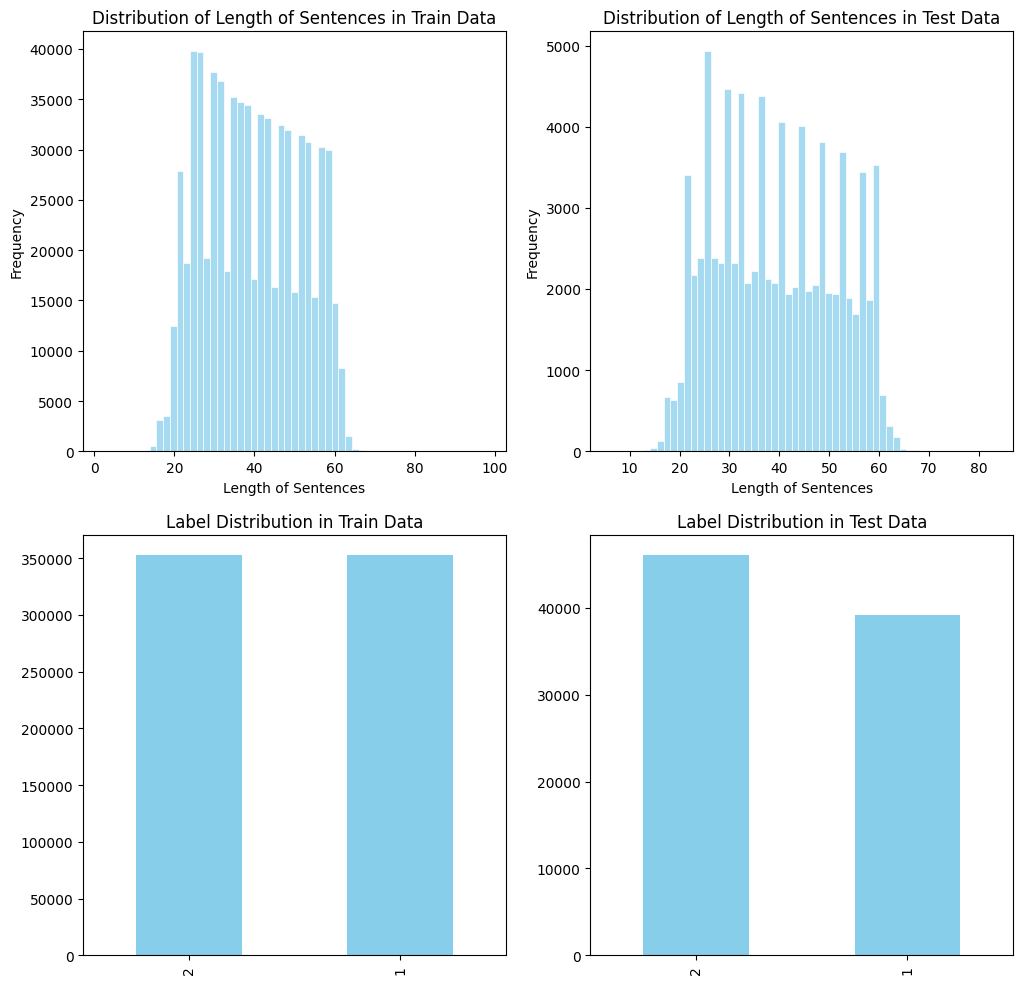

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

plot_length_distribution(train, name="Train", ax=axes[0][0])
plot_length_distribution(test, name="Test", ax=axes[0][1])
plot_label_distribution(train, name="Train", ax=axes[1][0])
plot_label_distribution(test, name="Test", ax=axes[1][1])

## Data Pipeline
- Label Pipeline
    - converting labels from [1, 2] to [0, 1], negative and positive respectively
- Text Pipeline
    - cleaning
    - tokenizing
    - vocab

### Text Pipeline

In [20]:
example_text = "This is, an example text"

#### 1. Cleaning

In [21]:
import re
def clean_text(text):
    # Remove extra spaces
    text = text.strip()
    # Convert multiple spaces to single spaces
    text = re.sub('\s+', ' ', text)
    # Lowercase the text
    text = text.lower()
    # Remove punctuation marks
    text = re.sub('[^\w\s]', '', text)
    return text

In [22]:
clean_text(example_text)

'this is an example text'

#### 2. Tokenizing

In [23]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [24]:
tokenizer(
    clean_text(example_text)
)

['this', 'is', 'an', 'example', 'text']

#### 3. Vocab

In [25]:
VOCAB_SIZE = 8_000

In [26]:
def vocab_iter(data):
    for row in data:
        text = row[1]
        yield tokenizer(clean_text(text))

In [27]:
print(next(vocab_iter(test)))

['works', 'fine', 'but', 'maha', 'energy', 'is', 'better', 'check', 'out', 'maha', 'energys', 'website', 'their', 'powerex', 'mhc204f', 'charger', 'works', 'in', '100', 'minutes', 'for', 'rapid', 'charge', 'with', 'option', 'for', 'slower', 'charge', 'better', 'for', 'batteries', 'and', 'they', 'have', '2200', 'mah', 'batteries']


In [28]:
vocab = torchtext.vocab.build_vocab_from_iterator(
    vocab_iter(train),
    specials=["<OOV>"],
    max_tokens = VOCAB_SIZE,
)
vocab.set_default_index(vocab["<OOV>"])

In [29]:
print(vocab.get_itos()[:20])

['<OOV>', 'the', 'i', 'and', 'a', 'it', 'this', 'to', 'is', 'of', 'for', 'not', 'in', 'was', 'my', 'book', 'but', 'you', 'that', 'with']


In [30]:
vocab(
    tokenizer(
        clean_text(example_text)
    )
)

[6, 8, 44, 1146, 727]

#### 4. Creating Pipeline

In [31]:
def TEXT_PIPELINE(text):
    return vocab(tokenizer(clean_text(text)))

TEXT_PIPELINE(example_text)

[6, 8, 44, 1146, 727]

### Label Pipeline

In [32]:
def LABEL_PIPELINE(label):
    return label - 1

LABEL_PIPELINE(2)

1

### Pipeline

In [33]:
def PIPELINE(sample):
    return (LABEL_PIPELINE(sample[0]), TEXT_PIPELINE(sample[1]))

print(PIPELINE(train[0]))

(1, [27, 9, 179, 224, 244, 253, 6, 8, 44, 118, 39, 18, 65, 28, 576, 70, 44, 624, 331, 38, 571, 433, 7, 0, 105, 3, 460, 25, 1126, 81, 163, 1, 39, 36, 416, 330, 4, 186, 3, 5, 47, 916, 27, 9, 179, 708, 1024])


In [34]:
new_train = []
for item in tqdm(train):
    new_train.append(PIPELINE(item))
train = new_train

new_test = []
for item in tqdm(test):
    new_test.append(PIPELINE(item))
test = new_test

100%|██████████| 704848/704848 [01:02<00:00, 11315.60it/s]

100%|██████████| 85135/85135 [00:06<00:00, 12192.95it/s]


## Dataloader

In [35]:
PADDING_IDX = vocab['<OOV>']

In [36]:
# this function is called when a batch is generated in from DataLoader
def collate_batch(batch):
    time_i = time.time()
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        text_list.append(torch.tensor(_text))
            
    label_list = torch.tensor(label_list, dtype=torch.float32).to(DEVICE)
    sequences =  torch.nn.utils.rnn.pad_sequence(
        text_list,
        batch_first = True,
        padding_value = PADDING_IDX
    ).to(DEVICE)

    return sequences, label_list

# this function decides how to split the dataset into batches, here sentences of similar lengths are kept in a batch together
class SortedSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, shuffle_times):
        self.batch_size = batch_size
        self.shuffle_times = shuffle_times

        # getting sorted index
        self.idx = [i[0] for i in sorted(enumerate(data_source), key=lambda x: len(x[1]))]

    def shuffle_idx(self):
        # starting points for each batch
        offsets = list(range(0, len(self.idx), self.batch_size))[:-1]
        # shuffling inter-batch
        for i in range(self.shuffle_times):
            i1, i2 = random.choices(offsets, k=2)
            self.idx[i1:i1+self.batch_size], self.idx[i2:i2+self.batch_size] = self.idx[i2:i2+self.batch_size], self.idx[i1:i1+self.batch_size]

    def __iter__(self):
        return iter(self.idx)

    def __len__(self):
        return len(self.idx)

# Modelling

## Custom Embeddings

In [37]:
from gensim.models import Word2Vec

# Initializing
model = Word2Vec(
    vector_size = 128,
    window = 5, 
    min_count = 1
)

# Vocabulary
model.build_vocab_from_freq({i: VOCAB_SIZE - i + 1 for i in range(VOCAB_SIZE)})
for k, v in model.wv.key_to_index.items():
    assert k == v

# Training
model.train(
    [i[1] for i in train],
    total_examples=len(train),
    epochs=3
)

# Extracting Embeddings
pretrained_embeddings = model.wv.vectors
pretrained_embeddings = torch.tensor(pretrained_embeddings)

pretrained_embeddings.shape

torch.Size([8000, 128])

In [38]:
word = "good"
print(f"Similar Words for \"{word}\":")
for i in model.wv.most_similar(vocab([word])[0]):
    print("->", vocab.get_itos()[i[0]])

Similar Words for "good":

-> great

-> decent

-> nice

-> bad

-> cool

-> excellent

-> neat

-> ok

-> okay

-> terrific


## Utilities

In [39]:
def accuracy(preds, labels):
    bools = preds.round() == labels
    return bools.sum(0) / len(bools)

def predict_texts(texts, _print=True):

    x, y = collate_batch(
        [[0, TEXT_PIPELINE(text)] for text in texts]
    )
    model.eval()
    preds = model(x)
    preds = preds.tolist()

    if _print:
        for pred, orig_text in zip(preds, texts):
            print(f"{int(round(pred))} ({round(pred, 3)}) - {orig_text}")
    else:
        return preds

def plot_history(history, skip_keys=[], splits=1, figsize=None):

    if figsize == None: figsize = (15, 15//len(history))
    fig, axs = plt.subplots(1, len(history), figsize=figsize)

    for i, (_key, _val) in enumerate(history.items()):
        for key, val in _val.items():
            if key in skip_keys: continue
            # creating splits
            val = torch.tensor(val)
            val = val[:(len(val) // splits) * splits].view(splits, -1).mean(axis=1)
            axs[i].plot(val, label=key)
        axs[i].legend()
        axs[i].set_title(_key)

    plt.show()

## Model Architechture
- Input `(batch_size, seq_len)`
- Embedding Layer `(batch_size, seq_len, emb_dim)`
- RNN Layer `(batch_size, seq_len, hidden_size)`
- Attention `(batch_size, seq_len, hidden_size)`
- RNN Layer `(batch_size, hidden_size)`
- Neural Network `(batch_size, inner_hidden_size)`
- Output `(batch_size, 1)`

In [50]:
def self_attention(Q, K, V):	
    d = K.shape[-1]
    QK = Q @ K.transpose(-2, -1)
    QK_d = QK / (d ** 0.5)
    weights = torch.softmax(QK_d, axis=-1)
    outputs = weights @ V
    return outputs

class Attention(torch.nn.Module):
    def __init__(self, emb_dim, n_heads):
        super(Attention, self).__init__()

        self.emb_dim = emb_dim
        self.n_heads = n_heads

    def forward(self, X):

        batch_size, seq_len, emb_dim = X.size() # (batch_size, seq_len, emb_dim)
        n_heads = self.n_heads
        emb_dim_per_head = emb_dim // n_heads

        assert emb_dim == self.emb_dim
        assert emb_dim_per_head * n_heads == emb_dim

        X = X.transpose(1, 2)
        output = self_attention(X, X, X)       # (batch_size, n_heads, seq_len, emb_dim_per_head)
        output = output.transpose(1, 2)   # (batch_size, seq_len, n_heads, emb_dim_per_head)
        output = output.contiguous().view(batch_size, seq_len, emb_dim)    # (batch_size, seq_len, emb_dim)

        return output

class ClassifierAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, padding_idx, hidden_size, n_layers, attention_heads, hidden_layer_units, dropout):
        super(ClassifierAttention, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = emb_dim,
            padding_idx = padding_idx
        )

        self.rnn_1 = nn.LSTM(
            emb_dim,
            hidden_size,
            n_layers,
            bidirectional = False,
            batch_first = True,
        )

        self.attention = Attention(hidden_size, attention_heads)

        self.rnn_2 = nn.LSTM(
            hidden_size,
            hidden_size,
            n_layers,
            bidirectional = False,
            batch_first = True,
        )

        self.dropout = nn.Dropout(dropout)

        hidden_layer_units = [hidden_size, *hidden_layer_units]
        self.hidden_layers = nn.ModuleList([])
        for in_unit, out_unit in zip(hidden_layer_units[:-1], hidden_layer_units[1:]):
            self.hidden_layers.append(nn.Linear(in_unit, out_unit))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(self.dropout)
        self.hidden_layers.append(nn.Linear(hidden_layer_units[-1], 1))

        self.sigmoid = nn.Sigmoid()

        self.add_custom_embeddings()

    def add_custom_embeddings(self):
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False

    def forward(self, x):
        # x: (batch_size, seq_len)

        out = self.embedding(x)     # (batch_size, seq_len, emb_dim)
        out, (hidden_state, cell_state) = self.rnn_1(out)
        out = self.attention(out)    # (batch_size, seq_len, hidden_size)
        out = self.dropout(out)
        output, (hidden_state, cell_state) = self.rnn_2(out)
        out = hidden_state[-1]      # (batch_size, hidden_size)
        out = self.dropout(out)
        # (batch_size, seq_len, hidden_dim)
        # (n_layers*n_direction, batch_size, hidden_size)
        # (n_layers*n_direction, batch_size, hidden_size)

        for layer in self.hidden_layers:
            out = layer(out)

        out = self.sigmoid(out) # (batch_size, 1)
        out = out.squeeze(-1)   # (batch_size)

        return out  


## Training

In [98]:
# DATA PARAMETERS
BATCH_SIZE = 8
TEST_BATCH_SIZE = 64
SHUFFLE_TIMES = 500_000
TRAIN_ITERATIONS_PER_EPOCH = N_TRAIN // BATCH_SIZE
TEST_ITERATIONS_PER_EPOCH = N_TEST // TEST_BATCH_SIZE
# MODEL PARAMETERS
EMB_DIM = 128
LSTM_HIDDEN_SIZE = 64
LSTM_N_LAYERS = 1
ATTENTION_HEADS = 2
HIDDEN_LAYER_UNITS = [64, 64]
DROPOUT = 0.4
# TRAINGING PARAMETERS
EPOCHS = 3
LR = 0.12
MOMENTUM = 0
SCHEDULER_STEP_SIZE = 1
SCHEDULER_FACTOR = 0.8
# TESTING PARAMETERS
INFO_SPLIT = 5
TEST_SENTENCES = [
    # negative sentences
    "I'm extremely disappointed with the quality of this item; it broke within a week.",
    "The customer support for this product is terrible; they were unhelpful and rude.",#
    "I had high expectations for this item, but it turned out to be a total letdown.",
    "The shipping was delayed, and the packaging was damaged when the product arrived.",
    "I encountered multiple issues with this item, and the manufacturer provided no solutions.",
    "The features advertised for this product are misleading; it doesn't perform as claimed.",#
    "I found this item to be overpriced for its quality; it doesn't justify the cost.",
    "The user interface is confusing and difficult to navigate; it's not user-friendly at all.",#

    # possitive sentences
    "The product exceeded my expectations and I am extremely satisfied with it.",#
    "This is the best product I've ever purchased, and I can't recommend it enough.",
    "The quality of the product is outstanding, and it's worth every penny.",#
    "I've had this item for a week now, and I'm impressed with its performance.",#
    "I was skeptical at first, but this product turned out to be a pleasant surprise.",
    "The product arrived in a damaged box, but fortunately, the item itself was fine.",#
    "I've tried many similar products, but this one stands out from the rest.",#
    "The features of this item are impressive, and it offers great value for money.",#
]

In [99]:
print("TRAIN_ITERATIONS_PER_EPOCH", TRAIN_ITERATIONS_PER_EPOCH)
print("TEST_ITERATIONS_PER_EPOCH", TEST_ITERATIONS_PER_EPOCH)

lr = LR
steps = 0
for i in range(EPOCHS):
    print(f"Epoch: {i+1}\tLR: {lr}")
    steps += 1
    if steps == SCHEDULER_STEP_SIZE:
        steps = 0
        lr *= SCHEDULER_FACTOR

TRAIN_ITERATIONS_PER_EPOCH 88106

TEST_ITERATIONS_PER_EPOCH 1330

Epoch: 1	LR: 0.12

Epoch: 2	LR: 0.096

Epoch: 3	LR: 0.07680000000000001


In [100]:
# ===> TRAIN DATALOADER
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size = BATCH_SIZE,
    collate_fn = collate_batch,
    sampler = SortedSampler(train, BATCH_SIZE, SHUFFLE_TIMES)
)

# ===> TEST DATALOADER
test_dataloader = torch.utils.data.DataLoader(
    test,
    batch_size = TEST_BATCH_SIZE,
    collate_fn = collate_batch,
    sampler = SortedSampler(test, TEST_BATCH_SIZE, 0)
)

In [101]:
# ===> MODEL
model = ClassifierAttention(VOCAB_SIZE, EMB_DIM, PADDING_IDX, LSTM_HIDDEN_SIZE, LSTM_N_LAYERS, ATTENTION_HEADS, HIDDEN_LAYER_UNITS, DROPOUT).to(DEVICE)

# ===> LOSS
criterion = nn.BCELoss()

# ===> OPTIMIZER
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

# ===> SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_FACTOR)

In [102]:
model

ClassifierAttention(
  (embedding): Embedding(8000, 128, padding_idx=0)
  (rnn_1): LSTM(128, 64, batch_first=True)
  (attention): Attention()
  (rnn_2): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [103]:
predict_texts(TEST_SENTENCES)

1 (0.502) - I'm extremely disappointed with the quality of this item; it broke within a week.

1 (0.502) - The customer support for this product is terrible; they were unhelpful and rude.

1 (0.502) - I had high expectations for this item, but it turned out to be a total letdown.

1 (0.502) - The shipping was delayed, and the packaging was damaged when the product arrived.

1 (0.502) - I encountered multiple issues with this item, and the manufacturer provided no solutions.

1 (0.502) - The features advertised for this product are misleading; it doesn't perform as claimed.

1 (0.502) - I found this item to be overpriced for its quality; it doesn't justify the cost.

1 (0.502) - The user interface is confusing and difficult to navigate; it's not user-friendly at all.

1 (0.502) - The product exceeded my expectations and I am extremely satisfied with it.

1 (0.502) - This is the best product I've ever purchased, and I can't recommend it enough.

1 (0.502) - The quality of the product is 

Epoch 1/3 ----> [ Loss: 0.415  Accuracy: 0.775  ]:  20%|██        | 17667/88106 [01:09<04:18, 272.65it/s]

Epoch 1/3 ----> [ Loss: 0.227  Accuracy: 0.9131 ]:  40%|████      | 35284/88106 [02:19<03:25, 256.90it/s]

Epoch 1/3 ----> [ Loss: 0.2092 Accuracy: 0.9212 ]:  60%|██████    | 52910/88106 [03:31<02:19, 253.17it/s]

Epoch 1/3 ----> [ Loss: 0.2009 Accuracy: 0.9248 ]:  80%|████████  | 70536/88106 [04:42<01:05, 269.96it/s]

Epoch 1/3 ----> [ Loss: 0.1921 Accuracy: 0.9275 ]: 100%|██████████| 88106/88106 [05:52<00:00, 249.70it/s]




Epoch 1/3 ----> [ Test Loss: 0.18662463441619875 Test Accuracy: 0.9306293827174392 ]



0 (0.0) - I'm extremely disappointed with the quality of this item; it broke within a week.

0 (0.0) - The customer support for this product is terrible; they were unhelpful and rude.

0 (0.031) - I had high expectations for this item, but it turned out to be a total letdown.

0 (0.084) - The shipping was delayed, and the packaging was damaged when the product arrived.

1 (0.541) - I encountered multiple issues with this item, and the manufacturer provided no solutions.

0 (0.01) - The features advertised for this product are misleading; it doesn't perform as claimed.

0 (0.005) - I found this item to be overpriced for its quality; it doesn't justify the cost.

0 (0.001) - The user interface is confusing and difficult to navigate; it's not user-friendly at all.

1 (0.998) - The product exceeded my expectations and I am extremely satisfied with it.

1 (0.999) - This is the best product I've ever pu

Epoch 2/3 ----> [ Loss: 0.1853 Accuracy: 0.9313 ]:  20%|██        | 17667/88106 [01:11<04:24, 266.79it/s]

Epoch 2/3 ----> [ Loss: 0.1778 Accuracy: 0.933  ]:  40%|████      | 35279/88106 [02:21<03:19, 264.97it/s]

Epoch 2/3 ----> [ Loss: 0.1778 Accuracy: 0.9335 ]:  60%|██████    | 52911/88106 [03:32<02:15, 260.12it/s]

Epoch 2/3 ----> [ Loss: 0.1772 Accuracy: 0.9348 ]:  80%|████████  | 70504/88106 [04:43<01:32, 190.34it/s]

Epoch 2/3 ----> [ Loss: 0.1735 Accuracy: 0.9363 ]: 100%|██████████| 88106/88106 [05:54<00:00, 248.62it/s]




Epoch 2/3 ----> [ Test Loss: 0.1825205061429374 Test Accuracy: 0.9331181129954257 ]



0 (0.0) - I'm extremely disappointed with the quality of this item; it broke within a week.

0 (0.0) - The customer support for this product is terrible; they were unhelpful and rude.

0 (0.018) - I had high expectations for this item, but it turned out to be a total letdown.

0 (0.165) - The shipping was delayed, and the packaging was damaged when the product arrived.

1 (0.874) - I encountered multiple issues with this item, and the manufacturer provided no solutions.

0 (0.015) - The features advertised for this product are misleading; it doesn't perform as claimed.

0 (0.003) - I found this item to be overpriced for its quality; it doesn't justify the cost.

0 (0.0) - The user interface is confusing and difficult to navigate; it's not user-friendly at all.

1 (0.999) - The product exceeded my expectations and I am extremely satisfied with it.

1 (0.998) - This is the best product I've ever purc

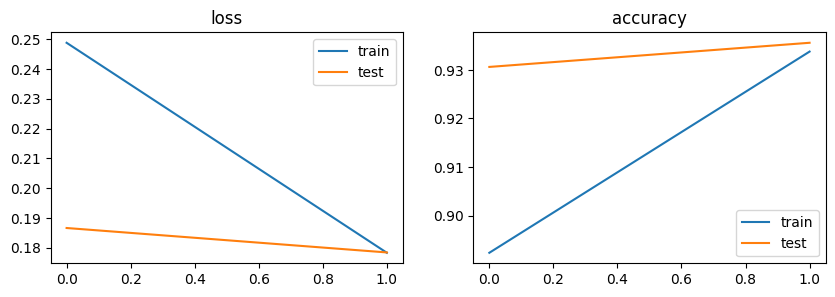

Epoch 3/3 ----> [ Loss: 0.1699 Accuracy: 0.9369 ]:  20%|██        | 17665/88106 [01:11<04:28, 262.54it/s]

Epoch 3/3 ----> [ Loss: 0.1653 Accuracy: 0.9385 ]:  40%|████      | 35282/88106 [02:23<04:16, 205.90it/s]

Epoch 3/3 ----> [ Loss: 0.1636 Accuracy: 0.9395 ]:  60%|██████    | 52917/88106 [03:33<02:09, 272.43it/s]

Epoch 3/3 ----> [ Loss: 0.1654 Accuracy: 0.9392 ]:  80%|████████  | 70512/88106 [04:44<01:07, 261.60it/s]

Epoch 3/3 ----> [ Loss: 0.1618 Accuracy: 0.9403 ]: 100%|██████████| 88106/88106 [05:54<00:00, 248.50it/s]




Epoch 3/3 ----> [ Test Loss: 0.17608294603450986 Test Accuracy: 0.9357174534920669 ]



0 (0.0) - I'm extremely disappointed with the quality of this item; it broke within a week.

0 (0.0) - The customer support for this product is terrible; they were unhelpful and rude.

0 (0.012) - I had high expectations for this item, but it turned out to be a total letdown.

0 (0.446) - The shipping was delayed, and the packaging was damaged when the product arrived.

1 (0.745) - I encountered multiple issues with this item, and the manufacturer provided no solutions.

0 (0.015) - The features advertised for this product are misleading; it doesn't perform as claimed.

0 (0.015) - I found this item to be overpriced for its quality; it doesn't justify the cost.

0 (0.0) - The user interface is confusing and difficult to navigate; it's not user-friendly at all.

1 (0.999) - The product exceeded my expectations and I am extremely satisfied with it.

1 (0.998) - This is the best product I've ever pur

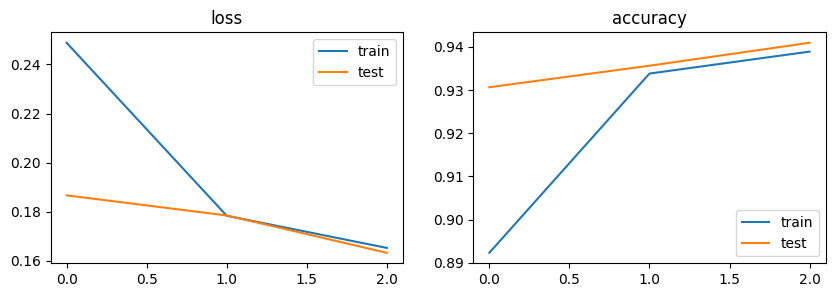

In [104]:
losses = {
    "train": [],
    "test": [],
}
metrics = {
    "train": [],
    "test": [],
}

for epoch in range(EPOCHS):

    # TRAINING
    with tqdm(total=TRAIN_ITERATIONS_PER_EPOCH) as pbar:
        model.train()
        temp_acc = 0
        temp_loss = 0
        i = 0
        for x, y in train_dataloader:
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            metric = accuracy(preds, y)

            losses['train'].append(loss.item())
            metrics['train'].append(metric.item())

            pbar.update(1)

            if pbar.n % (pbar.total // INFO_SPLIT) == 0:
                # interrupting the progress bar so last metrics and losses are visible
                # writing to progress bar
                round_to = 4
                temp_loss = str(round(np.mean(losses['train'][-pbar.total // INFO_SPLIT:]), round_to))
                temp_acc = str(round(np.mean(metrics['train'][-pbar.total // INFO_SPLIT:]), round_to))
                temp_loss += " " * (round_to + 2 - len(temp_loss))
                temp_acc += " " * (round_to + 2 - len(temp_acc))

                pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} ----> [ Loss: {temp_loss} Accuracy: {temp_acc} ]")
                print()

    # TESTING
    with torch.no_grad():
        model.eval()
        for x, y in test_dataloader:
            preds = model(x)
            loss = criterion(preds, y)
            metric = accuracy(preds, y)

            losses['test'].append(loss.item())
            metrics['test'].append(metric.item())
        print(f"Epoch {epoch+1}/{EPOCHS} ----> [ Test Loss: {np.mean(losses['test'])} Test Accuracy: {np.mean(metrics['test'])} ]")
        print()

    # END OF EPOCH
    scheduler.step()

    predict_texts(TEST_SENTENCES)
    print()

    if epoch > 0:
        plot_history(
            splits = epoch+1,
            skip_keys = [],
            figsize = (10, 10//3),
            history = {
                "loss": losses,
                "accuracy": metrics,
            }
        )


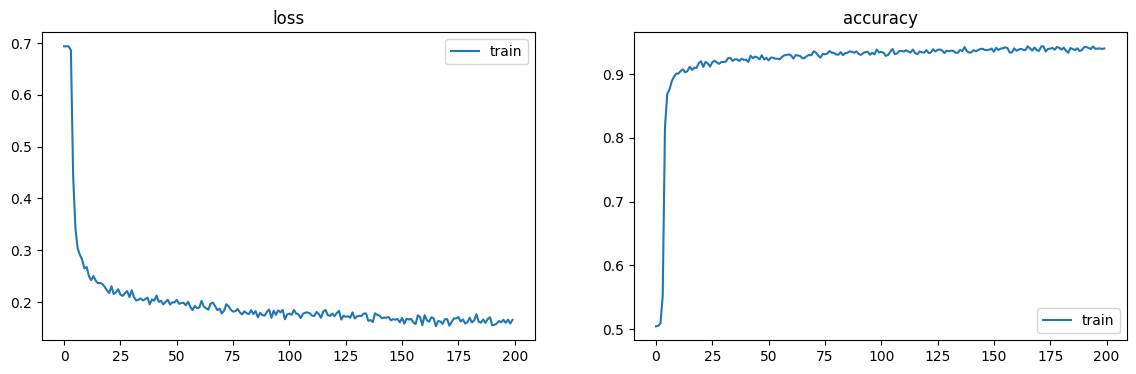

In [111]:
plot_history(
    splits = 200,
    skip_keys = [
        # "train",
        "test"
    ],
    figsize = (14, 14//3),
    history = {
        "loss": losses,
        "accuracy": metrics,
    }
)

## Validating

In [106]:
# GETTING THE PREDICTIONS

valid_preds = []
valid_labels = []
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        preds = model(x)
        valid_preds.extend(preds.round().type(torch.int32).tolist())
        valid_labels.extend(y.type(torch.int32).tolist())

Accuracy: 0.9409



Confusion Matrix:

[[36074  3042]

 [ 1991 44028]]




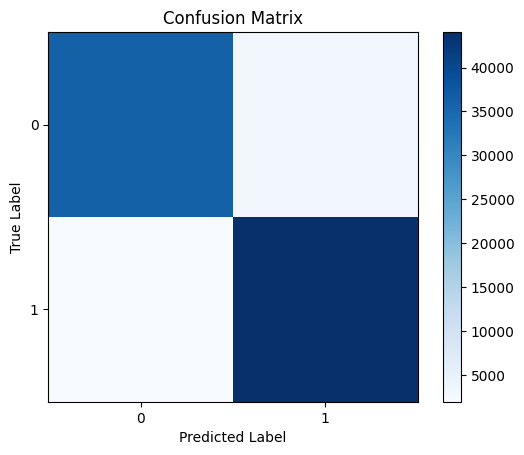



Precision: 0.9354

Recall: 0.9567

F1 Score: 0.9459



Classification Report:

              precision    recall  f1-score   support



           0       0.95      0.92      0.93     39116

           1       0.94      0.96      0.95     46019



    accuracy                           0.94     85135

   macro avg       0.94      0.94      0.94     85135

weighted avg       0.94      0.94      0.94     85135




In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy
acc = accuracy_score(valid_labels, valid_preds)
print(f"Accuracy: {acc:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds)
print()
print("Confusion Matrix:")
print(cm)
print()

# Plot heatmap of confusion matrix
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(valid_labels, valid_preds)
recall = recall_score(valid_labels, valid_preds)
f1 = f1_score(valid_labels, valid_preds)

print()
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
classification_rep = classification_report(valid_labels, valid_preds)
print()
print("Classification Report:")
print(classification_rep)

In [108]:
predict_texts(["that was not a bad experience of my life"])
predict_texts(["that was a bad experience of my life"])

1 (0.953) - that was not a bad experience of my life

1 (0.601) - that was a bad experience of my life


In [109]:
x, y = collate_batch(
    [[0, TEXT_PIPELINE(text)] for text in TEST_SENTENCES]
)
model.eval()
preds = model(x)
# preds = preds.round()
preds = preds.tolist()

for pred, orig_text in zip(preds, TEST_SENTENCES):
    print(f"Text: {orig_text}")
    print(f"Prediction: {['Negative Sentiment', 'Positive Sentiment'][int(round(pred))]} ( Confidence in Prediction: {abs(round(( pred - (1 - round(pred)) ) * 100 , 2))}% )")
    print()

Text: I'm extremely disappointed with the quality of this item; it broke within a week.

Prediction: Negative Sentiment ( Confidence in Prediction: 99.99% )



Text: The customer support for this product is terrible; they were unhelpful and rude.

Prediction: Negative Sentiment ( Confidence in Prediction: 99.95% )



Text: I had high expectations for this item, but it turned out to be a total letdown.

Prediction: Negative Sentiment ( Confidence in Prediction: 98.76% )



Text: The shipping was delayed, and the packaging was damaged when the product arrived.

Prediction: Negative Sentiment ( Confidence in Prediction: 55.43% )



Text: I encountered multiple issues with this item, and the manufacturer provided no solutions.

Prediction: Positive Sentiment ( Confidence in Prediction: 74.52% )



Text: The features advertised for this product are misleading; it doesn't perform as claimed.

Prediction: Negative Sentiment ( Confidence in Prediction: 98.47% )



Text: I found this item to be